In [158]:
# HIDDEN
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

In [159]:
# HIDDEN

def proportions(array):
    return array/np.sum(array)

### Two Categorical Distributions ###
To see how two quantitative variables are related, you could use the correlation coefficient to measure linear association. But how should we decide whether two categorical variables are related? For example, how can we decide whether a attribute is related to an individual's class? It's an important question to answer, because if it's not related then you can leave it out of your classifier.

In the breast cancer data, let's see if mitotic activity is related to the class. We have labeled the classes "Cancer" and "Not Cancer" for ease of reference later.

In [160]:
classes = Table().with_columns(
    'Class', make_array(0, 1),
    'Class Label', make_array('Not Cancer', 'Cancer')
)
patients = Table.read_table('breast-cancer.csv').drop('ID').join('Class', classes)
patients = patients.drop('Class').relabel('Class Label', 'Class')

In [161]:
mitoses = patients.select('Class', 'Mitoses')

In [162]:
mitoses

Class,Mitoses
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,5
Not Cancer,1
Not Cancer,1


We can use `pivot` and `proportions` (defined in the previous section) to visualize the distribution of `Mitoses` in the two classes.

In [163]:
counts = mitoses.pivot('Class', 'Mitoses')
counts

Mitoses,Cancer,Not Cancer
1,132,431
2,27,8
3,31,2
4,12,0
5,5,1
6,3,0
7,8,1
8,7,1
10,14,0


In [164]:
dists = counts.select(0).with_columns(
    'Cancer', proportions(counts.column(1)),
    'Not Cancer', proportions(counts.column(2))

)

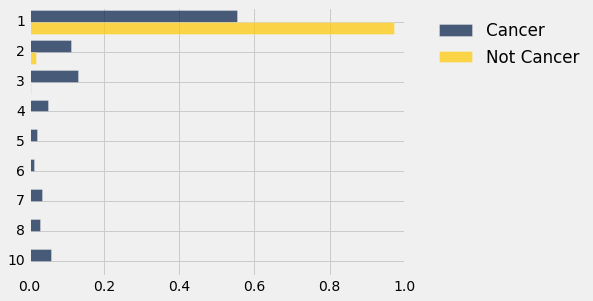

In [165]:
dists.barh(0)

The distribution of `Mitoses` for the 'Cancer' class has a long thin tail compared to the distribution for the 'Not Cancer' class which is overwhelmingly at the lowest rating. 

So it looks as though class and mitotic activity are related. But could this be just due to chance?

To understand where chance comes in, remember that the data are like a random sample from a larger population – the population that contains the new individuals whom we might want to classify. It could be that in the population, class and mitosis were independent of each other, and just appear to be related in the sample due to chance.

### The Hypotheses ###
Let's try to answer the question by performing a test of the following hypotheses.

**Null Hypothesis.** In the population, class and mitosis ratings are independent of each other; in other words, the distribution of mitoses is the same for the two classes. The distributions are different in the sample only due to chance.

**Alternative Hypothesis.** In the population, class and mitosis ratings are related.

To see how to test this, let's look at the data again.

In [166]:
mitoses

Class,Mitoses
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,1
Not Cancer,5
Not Cancer,1
Not Cancer,1


### Random Permutations ###

If class and mitosis ratings are unrelated, then it doesn't matter in what order the `Mitoses` values appear – since they are not related to the values in `Class`, all rearrangements should be equally likely. This is the same as the approach that we took when analyzing the football Deflategate data.

So let's shuffle all the `Mitoses` values into an array called `shuffled_mitoses`. You can see its first item below, but it contains 683 items because it is a permutation (that is, a rearrangement) of the entire `Mitoses` column.

In [182]:
shuffled_mitoses = mitoses.select('Mitoses').sample(with_replacement=False).column(0)

In [183]:
shuffled_mitoses.item(0)

1

Let's augment the table `mitoses` with a column containing the shuffled values.

In [184]:
mitoses = mitoses.with_column('Shuffled Mitoses', shuffled_mitoses)

In [185]:
mitoses

Class,Mitoses,Shuffled Mitoses
Not Cancer,1,1
Not Cancer,1,1
Not Cancer,1,1
Not Cancer,1,1
Not Cancer,1,7
Not Cancer,1,1
Not Cancer,1,1
Not Cancer,5,3
Not Cancer,1,1
Not Cancer,1,2


Let's look at the distributions of mitoses for the shuffled data, using the same process that we followed with the original data.

In [186]:
shuffled = mitoses.select('Class', 'Shuffled Mitoses')

shuffled_counts = shuffled.pivot('Class', 'Shuffled Mitoses')

shuffled_counts

Shuffled Mitoses,Cancer,Not Cancer
1,199,364
2,12,23
3,12,21
4,5,7
5,2,4
6,0,3
7,3,6
8,3,5
10,3,11


The distributions of the shuffled data in the two classes can be visualized in bar charts just as the original data were.

In [187]:
shuffled_dists = shuffled_counts.select(0).with_columns(
    'Cancer', proportions(shuffled_counts.column(1)),
    'Not Cancer', proportions(shuffled_counts.column(2))
)

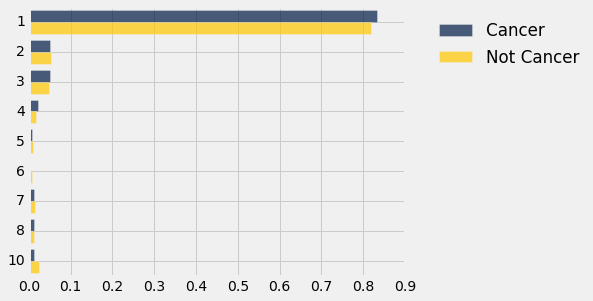

In [188]:
shuffled_dists.barh(0)

That looks a bit different from the original bar charts, shown below again for convenience.

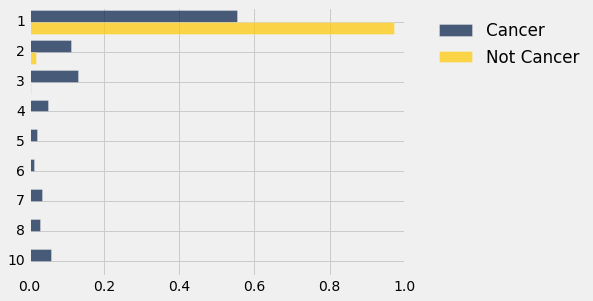

In [189]:
dists.barh(0)

### A Test Statistic: Total Variation Distance ###

We need a test statistic that measures the difference between the blue distribution and the gold. Recall that total variation distance can be used to quantify how different two categorical distributions are. 

In [175]:
def tvd(dist1, dist2):
    return 0.5*(np.sum(np.abs(dist1 - dist2)))

In the original sample, the total variation distance between the distributions of mitoses in the two classes was about 0.4:

In [190]:
observed_tvd = tvd(dists.column(1), dists.column(2))
observed_tvd

0.41841946549059517

But in the shuffled sample it was quite a bit smaller:

In [191]:
tvd(shuffled_dists.column(1), shuffled_dists.column(2))

0.022173847487655045

The randomly permuted mitosis ratings and the original ratings don't seem to be behaving the same way. But the random shuffle could come out differently if we run it again. Let's reshuffle and redo the calculation of the total variation distance.

In [194]:
shuffled_mitoses = mitoses.select('Mitoses').sample(with_replacement=False).column(0)

shuffled = mitoses.select('Class').with_column('Shuffled Mitoses', shuffled_mitoses)

shuffled_counts = shuffled.pivot('Class', 'Shuffled Mitoses')

tvd(proportions(shuffled_counts.column(1)), proportions(shuffled_counts.column(2)))

0.039937426966715643

The total variation distance is still quite a bit smaller than the 0.42 we got from the original data. To see how much it could vary, we have to repeat the random shuffling procedure many times, in a process that has by now become familiar.

### Empirical Distribution of the TVD, Under the Null Hypothesis ###
If the null hypothesis were true, all permutations of mitosis ratings would be equally likely. There are large numbers of possible permutations; let's do 5000 of them and see how our test statistic varies. The code is exactly the same as above, except that now we will collect all 5000 distances and draw their empirical histogram.

Observed TVD: 0.418419465491


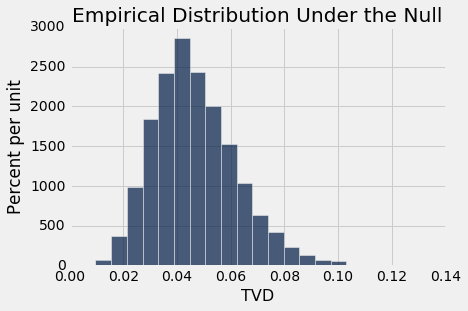

In [179]:
repetitions = 5000
tvds = make_array()
for i in np.arange(repetitions):
    shuffled_mitoses = mitoses.select('Mitoses').sample(with_replacement=False).column(0)
    shuffled = mitoses.select('Class').with_column('Shuffled Mitoses', shuffled_mitoses)
    shuffled_counts = shuffled.pivot('Class', 'Shuffled Mitoses')
    new_tvd = tvd(proportions(shuffled_counts.column(1)), proportions(shuffled_counts.column(2)))
    tvds = np.append(tvds, new_tvd)

Table().with_column('TVD', tvds).hist(bins=20)
plots.title('Empirical Distribution Under the Null')
print('Observed TVD:', observed_tvd)

The observed total variation distance of 0.42 is nowhere near the distribution generated assuming the null hypothesis is true. The data support the alternative: the mitosis ratings are related to class.

### Permutation Test for the Equality of Two Categorical Distributions ###
The test that we performed above is called a *permutation test* of the null hypothesis that the two samples are drawn from the same underlying distribution. 

To define a function that performs the test, we can just copy the code from the previous cell and change the names of tables and columns. The function `permutation_test_tvd` takes the name of the data table, the label of the column containing the categorical variable whose distribution the test is about, the label of the column containing the binary class variable, and the number of random permutations to run.

In our example above, we didn't compute a P-value because the observed value was far away from the null distribution of the statistic. In general, however, we should compute the P-value as the statistic might not be so extreme in other examples. The P-value is the chance, assuming that the null is true, of getting a distance as big as or bigger than the distance that was observed, because the alternative hypothesis predicts larger distances than the null.


In [180]:
def permutation_test_tvd(table, variable, classes, repetitions):
    
    """Test whether a categorical variable is independent of classes:
    table: name of table containing the sample
    variable: label of column containing categorical variable whose distribution is of interest
    classes: label of column containing binary class data
    repetitions: number of random permutations"""
    
    # Find the tvd between the distributions of variable in the two classes
    counts = table.select(classes, variable).pivot(classes, variable)
    observed_tvd = tvd(proportions(counts.column(1)), proportions(counts.column(2)))
    
    # Assuming the null is true, randomly permute the variable and collect all the new tvd's
    tvds = make_array()
    for i in np.arange(repetitions):
        shuffled_var = table.select(variable).sample(with_replacement=False).column(0)
        shuffled = table.select(classes).with_column('Shuffled Variable', shuffled_var)
        shuffled_counts = shuffled.pivot(classes, 'Shuffled Variable')
        new_tvd =tvd(proportions(shuffled_counts.column(1)), proportions(shuffled_counts.column(2)))
        tvds = np.append(tvds, new_tvd)
    
    # Find the empirical P-value:
    emp_p = np.count_nonzero(tvds >= observed_tvd)/repetitions

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    Table().with_column('TVD', tvds).hist(bins=20)
    plots.title('Empirical Distribution Under the Null')
    print('Observed TVD:', observed_tvd)
    print('Empirical P-value:', emp_p)

Observed TVD: 0.638310905047
Empirical P-value: 0.0


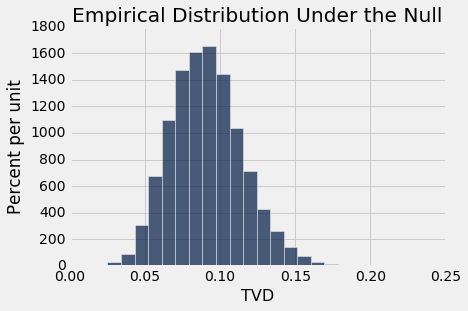

In [195]:
permutation_test_tvd(patients, 'Clump Thickness', 'Class', 5000)

Once again, the observed distance of 0.64 is very far away from the distribution predicted by the null hypothesis. The empirical P-value is 0, so the exact P-value will be close to zero. Thus if class and clump thickness were unrelated, the observed data would be hugely unlikely.

So the conclusion is that clump thickness is related to class, not just in the sample but in the population.

We have use permutation tests to help decide whether the distribution of a categorical attribute is related to class. In general, permutation tests can be used in this way to decide whether two categorical distributions were randomly sampled from the same underlying distribution.